# Tutorial of Moneyball Data Analysis

### In this tutorial, I provide a walk-through of how I analyze how efficient baseball teams have been historically spending money and getting wins in return. In the case of Moneyball, one would expect that Oakland was not much more efficient than other teams in their spending before 2000, were much more efficient between 2000 and 2005, and by then other teams may have caught up. My goal in this project is to see how this is reflected in data. I wrangle, transform, and analyze data from [Lahman's Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/)  which contains information on baseball teams, players and seasons curated by Sean Lahman. Specifically, I look at [Lahman's 2014 data](https://github.com/jknecht/baseball-archive-sqlite/blob/master/lahman2014.sqlite) using the Python sqlite and pandas packages to access the data and load it into a pandas dataframe. 

In [ ]:
import sqlite3
import pandas as pd
import os.path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

## <u>Part 1: Wrangling</u>

First, I use sqlite to connect to the Lahman 2014 database found on [SeanLahman.com](https://www.seanlahman.com/baseball-archive/statistics/).

In [ ]:
sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

Next, I query the data to compute a relation containing the total payroll and winning percentage (number of wins / number of games * 100) for each team. I also include columns for League ID, Franchise ID, Division ID, Rank, Wins, and Games to use later for my exploratory analysis. 

In [ ]:
salary_query = "SELECT yearID, teamID, sum(salary) as total_payroll FROM Salaries GROUP BY yearID, teamID"
win_percent_query = "SELECT  yearID, teamID, lgID, divID, rank, W,G, (((W*1.0)/G)*100) as win_percentage \
                    FROM Teams GROUP BY yearID, teamID" 

I then load the two sqlite queries for salary and win percentage as two pandas dataframes and merge them into one dataframe. 

In [ ]:
# Read in data as two pandas dataframes
team_salaries = pd.read_sql(salary_query, conn)
team_win_percent = pd.read_sql(win_percent_query, conn)

The salary data contains total payroll for teams from 1985 up to 2014, and the win percentage data contains win percentages for each team from 1871 to 2014. Thus, there is definitely missing data between 1871 and 1985. To account for the missing data from this time discrepancy and any additional missing data, I use an inner join, which is the result of the intersection of the two tables. To merge the data from each team and year, I joined both left and right dataframes on yearID and teamID.

In [ ]:
# Merge salary and win percentage dataframes as one
team_win_salaries = team_salaries.merge(team_win_percent, how ="inner", left_on=["yearID", "teamID"],right_on=["yearID", "teamID"])

# Compute results of one team over the time range 
one_team = team_win_salaries[team_win_salaries["teamID"] == "BAL"]

# Display head of the resulting dataframe & results of one team over the time range
display(team_win_salaries.head())
display(one_team)

,yearID,teamID,total_payroll,lgID,divID,Rank,W,G,win_percentage
0,1985,ATL,14807000.0,NL,W,5,66,162,40.740741
1,1985,BAL,11560712.0,AL,E,4,83,161,51.552795
2,1985,BOS,10897560.0,AL,E,5,81,163,49.693252
3,1985,CAL,14427894.0,AL,W,2,90,162,55.555556
4,1985,CHA,9846178.0,AL,W,3,85,163,52.147239


,yearID,teamID,total_payroll,lgID,divID,Rank,W,G,win_percentage
1,1985,BAL,11560712.0,AL,E,4,83,161,51.552795
27,1986,BAL,13001258.0,AL,E,7,73,162,45.061728
53,1987,BAL,13900273.0,AL,E,6,67,162,41.358025
79,1988,BAL,13532075.0,AL,E,7,54,161,33.540373
105,1989,BAL,8275167.0,AL,E,2,87,162,53.703704
131,1990,BAL,9680084.0,AL,E,5,76,161,47.204969
157,1991,BAL,17519000.0,AL,E,6,67,162,41.358025
183,1992,BAL,23780667.0,AL,E,3,89,162,54.938272
209,1993,BAL,29096500.0,AL,E,3,85,162,52.469136
237,1994,BAL,38849769.0,AL,E,2,63,112,56.250000


## <u>Part 2: Exploratory Data Analysis</u>

## Payroll Distribution

First, I plot a boxplot displaying the distribution of payrolls across teams conditioned on time (from 1990-2014). The below boxplot shows the distribution of payrolls across teams. Based on the boxplot, we can see that the spread of the highest team payroll increases over time, reaching an all time high in 2014, and the average total payroll for each team increases over time.

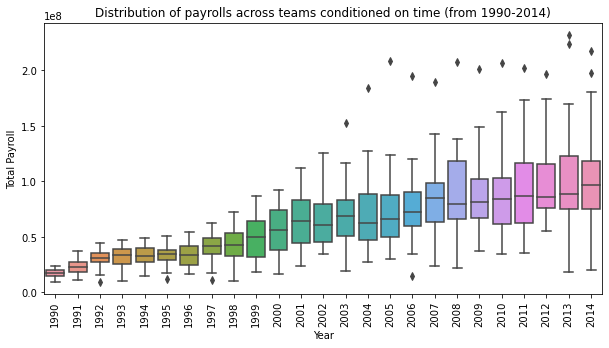

In [ ]:
# Filter by data from years 1990-2014
payroll_1990 = team_win_salaries[team_win_salaries['yearID'] >= 1990]

# Plot boxplot of total payroll data for teams from 1990-2014
ax = sns.boxplot(data = payroll_1990, x='yearID',y=('total_payroll'))

# Rotate years by 90 degrees
for item in ax.get_xticklabels():
    item.set_rotation(90)
    
plt.gcf().set_size_inches(10, 5)
plt.ylabel('Total Payroll')
plt.xlabel('Year')
plt.title('Distribution of payrolls across teams conditioned on time (from 1990-2014)')
plt.show()

Second, I plot a scatter plot that shows winning percentage as a function of total payroll. The below scatter plot shows the winning percentage as a function of total payroll. Based on the scattter plot, we can see a general trajectory of points going slightly up to the right. This indicates that there is a positive correlation between winning percentage and total payroll.

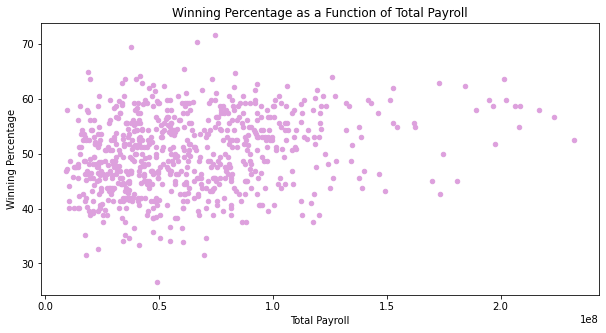

In [ ]:
ax2 = payroll_1990.plot.scatter(x='total_payroll',y='win_percentage',c='plum')
plt.gcf().set_size_inches(10, 5)
plt.xlabel('Total Payroll')
plt.ylabel('Winning Percentage')
plt.title('Winning Percentage as a Function of Total Payroll')
plt.show()

Next, I plot two bar graphs.

The first graph plots the average total payroll for each year from 1990-2014. From this graph, we can see that the average total payroll steadily increases from 1990 to 2014.

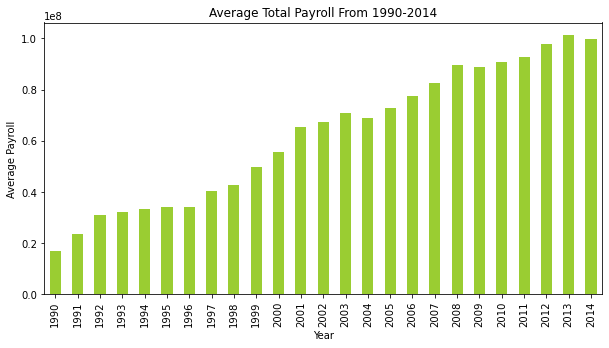

In [ ]:
# Plot bar graph of average total payrolls
payroll_avg = payroll_1990.groupby(["yearID"])["total_payroll"].mean()
ax3 = payroll_avg.plot.bar(rot=90, color='yellowgreen')
plt.gcf().set_size_inches(10, 5)
plt.title('Average Total Payroll From 1990-2014')
plt.ylabel('Average Payroll')
plt.xlabel('Year')
plt.show()

The second bar graph plots the range (maximum payroll - minimum payroll) of payrolls for each year from 1990-2014. From this graph, we can see that the range of payrolls increases from 1990 to 2014.

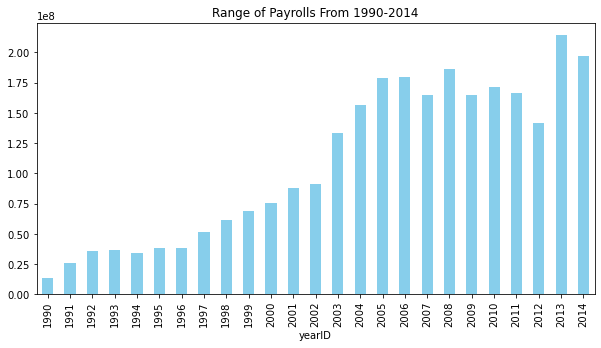

In [ ]:
# Calculate range by subtracting max and min payroll values
payroll_min_max = payroll_1990.groupby('yearID')['total_payroll'].agg([min,max])

payroll_min_max['difference'] = payroll_min_max['max'] - payroll_min_max['min']

# Plot bar graph of range of payrolls
payroll_min_max.difference.plot.bar(stacked=True, rot=90, color=(['skyblue']))
plt.gcf().set_size_inches(10, 5)
plt.title('Range of Payrolls From 1990-2014')
plt.show()

## Correlation Between Payroll and Winning Percentage

First, I discretize year into five time periods (1990-1995, 1995-2000, 2000-2005, 2005-2010, 2010-2014) using pandas .cut function.

In [ ]:
# Discretize year into five time periods
periods = ['period_1','period_2','period_3','period_4','period_5']
team_win_salaries['time_period'] = pd.cut(team_win_salaries['yearID'],[1990,1995,2000,2005,2010,2015] \
                                          ,right=False, labels=periods)

I then make a set of scatter plot showing average winning percentage (y-axis) vs. average payroll (x-axis) for each of the five time periods. Each point on the graph represents a specific team's payroll. I add a regression line to better visualize the correlation.

Average Winning Percentage (y-axis) vs. Average Payroll (x-axis) for each of the Five Time Periods


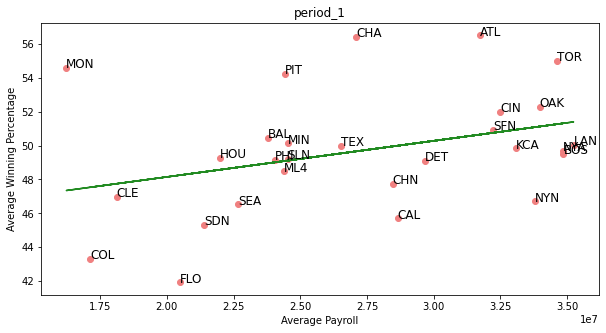

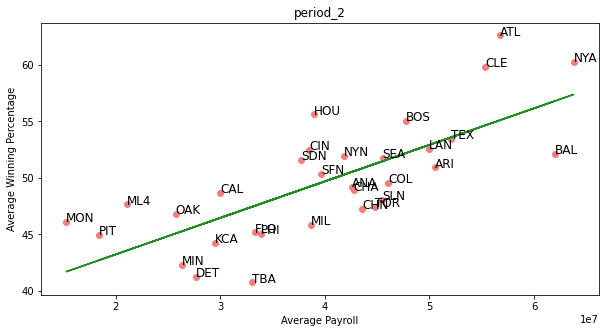

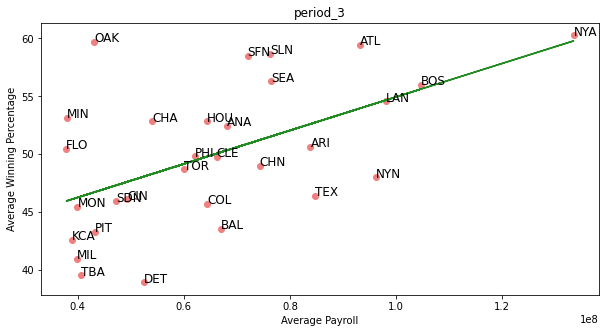

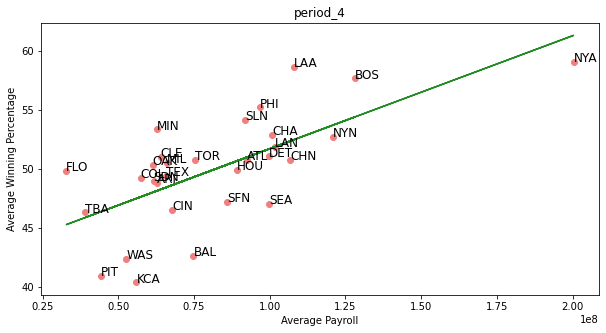

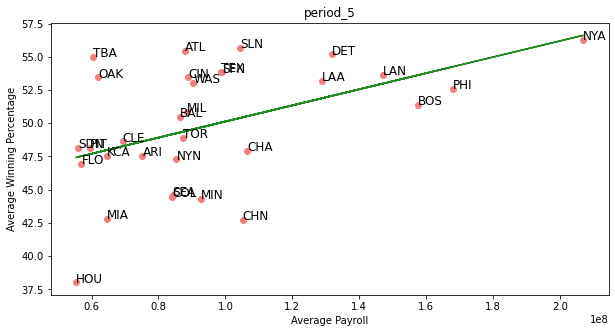

In [ ]:
# Transform payroll data
payroll_df = team_win_salaries[team_win_salaries['yearID'] >= 1990]
payroll_df = payroll_df.set_index('yearID')

print("Average Winning Percentage (y-axis) vs. Average Payroll (x-axis) for each of the Five Time Periods")

for period in periods:
    per_winning = payroll_df[payroll_df['time_period'] == period].groupby(by=["time_period", "teamID"])['win_percentage'].mean()
    per_winning = per_winning.dropna()
    per_payroll =  payroll_df[payroll_df['time_period'] == period].groupby(by=["time_period", "teamID"])['total_payroll'].mean()
    per_payroll = per_payroll.dropna()

    # Make scatter plot
    plt.figure(figsize = (10, 5))
    plt.scatter(per_payroll, per_winning, color='lightcoral')
    plt.title(period)
    
    # Plot Regression Line
    m, b = np.polyfit(per_payroll.values, per_winning.values, deg = 1)
    plt.plot(per_payroll.values, m * per_payroll.values + b, color = 'forestgreen')
    
    # Annotate team names to scatter plot values 
    per_payroll = per_payroll.reset_index()
    per_winning = per_winning.reset_index()
    
    for i, team in enumerate(per_payroll.teamID):
        plt.annotate(team, (per_payroll.values[i][2], per_winning.values[i][2]),size=12)
    
    
    plt.xlabel("Average Payroll")
    plt.ylabel("Average Winning Percentage")
    plt.show()

The above scatter plots show that there is a positive correlation between average winning percentage and average payroll. On average, most teams with higher payrolls appear to have a higher winning percentage. ATL and NYA appear to be particularly good at paying for wins. Apart from period 1, the Oakland A's appear to be at the lower end of the payroll distribution. During period 3 (2000-2005), the Oakland A's have the highest winning percentage despite its payroll being significantly less than the majority of teams. In periods 4 and 5, the Oakland A's continue to have low payrolls and one of the highest winning percentages. This shows that its efficiency in spending and getting wins is high during that time, allowing the team to beat high-paid teams.

## <u>Part 3: Data Transformations</u>

## Standardizing Across Years

Here, I create a new variable that standardizes payroll conditioned on year. For this, I compute the Z-score of the variables using the value of the payroll, the average payroll, and standard deviation of the payroll.

In [ ]:
# Compute average & standard deviation of payrolls according to year
payroll_avg = payroll_avg.reset_index()
payroll_std = payroll_df.groupby(["yearID"])["total_payroll"].std()
payroll_std = payroll_std.reset_index()

# Create new dataframe columns for average payroll and standard deviation payroll
payroll_df['average_payroll'] = ""
payroll_df['standard_deviation_payroll'] = ""

# Loop through payrolls
for index, row in payroll_df.iterrows():

    # Compute average and standard deviation for each row
    payroll = row[1]
    avg_payroll = payroll_avg[payroll_avg['yearID'] == index]['total_payroll'].tolist()[0]
    std_payroll = payroll_std[payroll_std['yearID'] == index]['total_payroll'].tolist()[0]
    
    # Append computed values to payroll dataframe
    payroll_df.at[index, 'average_payroll'] = avg_payroll
    payroll_df.at[index, 'standard_deviation_payroll'] = std_payroll

# Compute standardized payroll
payroll_df['standardized_payroll'] = (payroll_df['total_payroll'] - payroll_df['average_payroll']) /  payroll_df['standard_deviation_payroll']
    
display(payroll_df.head())

,teamID,total_payroll,lgID,divID,Rank,W,G,win_percentage,time_period,average_payroll,standard_deviation_payroll,standardized_payroll
yearID,,,,,,,,,,,,
1990,ATL,14555501.0,NL,W,6,65,162,40.123457,period_1,17072353.576923,3771834.264904,-0.667275
1990,BAL,9680084.0,AL,E,5,76,161,47.204969,period_1,17072353.576923,3771834.264904,-1.959861
1990,BOS,20558333.0,AL,E,1,88,162,54.320988,period_1,17072353.576923,3771834.264904,0.924213
1990,CAL,21720000.0,AL,W,4,80,162,49.382716,period_1,17072353.576923,3771834.264904,1.232198
1990,CHA,9491500.0,AL,W,2,94,162,58.024691,period_1,17072353.576923,3771834.264904,-2.009859


I repeat the scatter same plots as shown above, but use the standardized payroll variable instead of the total payroll variable. This scatter plot shows the average winning percentage (y-axis) vs. average standardized payroll (x-axis) for each of the five time periods. Each point on the graph represents a specific team's standardized payroll. I add a regression line to better visualize the correlation.

Average Winning Percentage (y-axis) vs. Average Standardized Payroll (x-axis) for each of the Five Time Periods


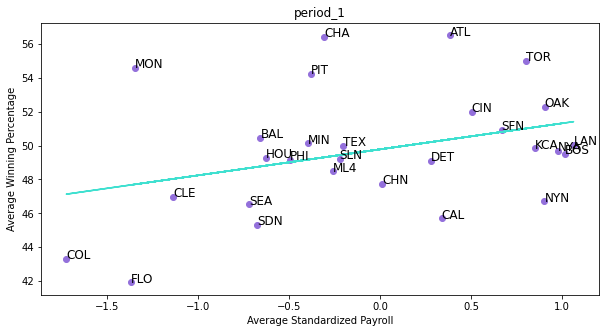

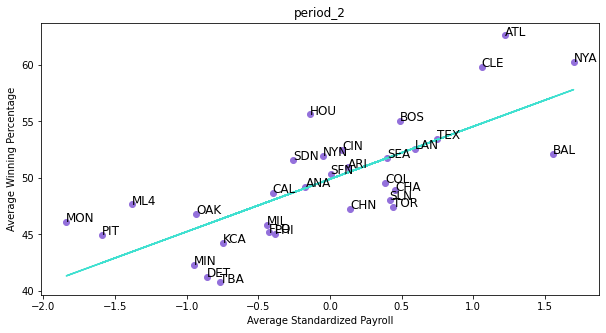

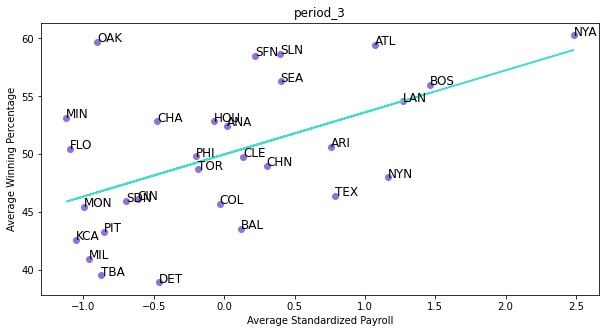

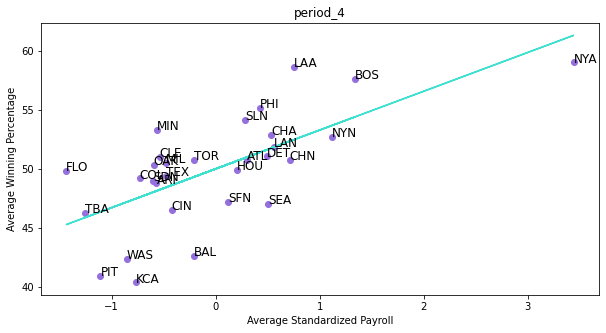

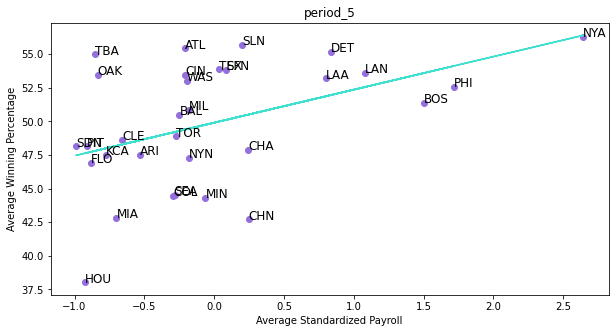

In [ ]:
print("Average Winning Percentage (y-axis) vs. Average Standardized Payroll (x-axis) for each of the Five Time Periods")

for period in periods:
    per_winning = payroll_df[payroll_df['time_period'] == period].groupby(by=["time_period", "teamID"])['win_percentage'].mean()
    per_winning = per_winning.dropna()
    per_payroll =  payroll_df[payroll_df['time_period'] == period].groupby(by=["time_period", "teamID"])['standardized_payroll'].mean()
    per_payroll = per_payroll.dropna()

    # Make scatter plot
    plt.figure(figsize = (10, 5))
    plt.scatter(per_payroll, per_winning, color='mediumpurple')
    plt.title(period)
    
    # Plot Regression Line
    m, b = np.polyfit(per_payroll.values, per_winning.values, deg = 1)
    plt.plot(per_payroll.values, m * per_payroll.values + b, color='turquoise')
    
    # Annotate team names to scatter plot values 
    per_payroll = per_payroll.reset_index()
    per_winning = per_winning.reset_index()
    
    for i, team in enumerate(per_payroll.teamID):
        plt.annotate(team, (per_payroll.values[i][2], per_winning.values[i][2]),size=12)
    
    plt.xlabel("Average Standardized Payroll")
    plt.ylabel("Average Winning Percentage")
    plt.show()

The points on the scatter plots of the average total payroll are more difficult to compare than the scatter plots of the average standardized payroll. This is the case because each time period plot has a different payroll scale. In the scatter plots of the average standaradized payroll above, the standardized payroll data represents the payroll data from the average total payroll on standard scale. Thus, average payrolls for each period are able to be compared more easily without giving one payroll a greater weight than another. On this standardized scale, it is more apparent that teams with higher payrolls typically have a higher winning percentage. It is also easier to see that Oakland was not much more efficient than other teams in their spending in periods 1 and 2, were much more efficient in period 3, and by period 4, other teams may have caught up. 

## Expected Wins

Here, I make a single scatter plot of winning percentage (y-axis) vs. standardized payroll (x-axis) and add a regression line to highlight the relationship.

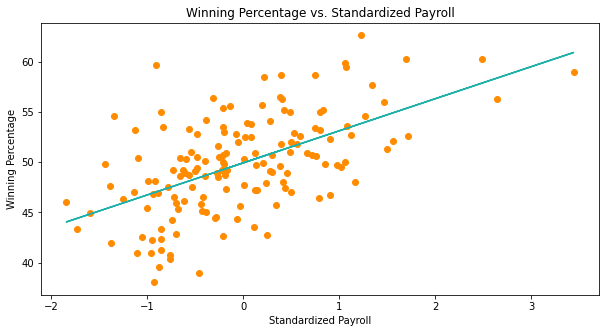

In [ ]:
per_winning = payroll_df.groupby(by=["time_period", "teamID"])['win_percentage'].mean()
per_winning = per_winning.dropna()
per_payroll =  payroll_df.groupby(by=["time_period", "teamID"])['standardized_payroll'].mean()
per_payroll = per_payroll.dropna()

# Make scatter plot
plt.figure(figsize = (10, 5))
plt.scatter(per_payroll, per_winning, color='darkorange')
plt.ylabel('Winning Percentage')
plt.xlabel('Standardized Payroll')
plt.title("Winning Percentage vs. Standardized Payroll")

# Plot Regression Line
m, b = np.polyfit(per_payroll.values, per_winning.values, deg = 1)
plt.plot(per_payroll.values, m * per_payroll.values + b, color='lightseagreen')

plt.show()

The regression line gives you expected winning percentage as a function of standardized payroll. Looking at the regression line, it looks like teams that spend roughly the average payroll in a given year will win 50% of their games (i.e. win_pct is 50 when standardized_payroll is 0), and teams increase 5% wins for every 2 standard units of payroll (i.e., win_pct is 55 when standardized_payroll is 2). From these observations, I calculate the expected win percentage for team i in year j.

In [ ]:
payroll_df['expected_win_pct'] = 50 + 2.5*payroll_df['standardized_payroll']

## Spending Efficiency

I now create a single plot that makes it easier to compare teams efficiency. I create a new measurement unit for each team based on their winning percentage and their expected winning percentage that can be plotted across time summarizing how efficient each team is in their spending.

First, I create a new field to compute each team’s spending efficiency, for team i in year j.

In [ ]:
payroll_df['efficiency'] = payroll_df['win_percentage'] - payroll_df['expected_win_pct']

Next, I make a line plot with year on the x-axis and spending efficiency on the y-axis for Oakland, the New York Yankees, Boston, Atlanta and Tampa Bay. Each line represents a specific team's spending efficiency.

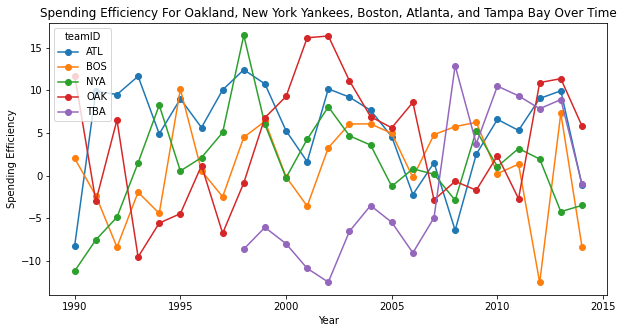

In [ ]:
# Create dataframe for Oakland, the New York Yankees, Boston, Atlanta and Tampa Bay spending efficiency
teams_payroll = payroll_df.loc[(payroll_df['teamID'] == 'OAK') | (payroll_df['teamID'] == 'NYA') | (payroll_df['teamID'] == 'BOS') | \
                 (payroll_df['teamID'] == 'ATL') | (payroll_df['teamID'] == 'TBA')]
teams_payroll = teams_payroll.reset_index()
team_efficiency = teams_payroll.pivot(index='yearID', columns='teamID', values='efficiency')

# Plot spending efficiency
team_efficiency.plot(kind = 'line',title ="Spending Efficiency For Oakland, New York Yankees, Boston, Atlanta, and Tampa Bay Over Time", \
                     marker='o', legend=True, figsize=(10,5))

plt.xlabel("Year")
plt.ylabel("Spending Efficiency")
plt.show()


The above line plot with year on the x-axis and spending efficiency on the y-axis for Oakland, the New York Yankees, Boston, Atlanta and Tampa Bay. Each line represents a specific team's spending efficiency. This plot shows that the spending efficiency of teams is variable and changes each year. Compared to the set of plots I looked at in earlier, this plot determines the spending efficiency of teams directly over the course of the time periods. This plot shows that Oakland's spending efficiency was at its highest and higher than that of New York, Boston, Atlanta, and Tampa Bay during the Moneyball period between 2000 and 2005. Additionally, this plot shows that some teams with historically high payrolls still had periods of high spending efficiency, such as NYA between 1995-2000. 

### I hope you enjoyed reading this tutorial! Thank you!!